<a href="https://colab.research.google.com/github/CBaffelli/CAS-NLP_Machine-translation/blob/main/02_CAS_NLP_final_project_data_preprocessing_and_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install spacy

# **Dataset analysis**

This script is used to analyze the data which is then used for the fine-tuning of a multilingual machine translation model.

In [ ]:
#@title Imports and varia
import pandas as pd
import os
import spacy
from spacy.lang.en import English
from spacy.lang.it import Italian
from spacy.lang.es import Spanish
from spacy.lang.fr import French
from spacy.lang.pt import Portuguese
from spacy.lang.ro import Romanian
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from wordcloud import WordCloud
import seaborn as sns
import numpy as np
from collections import Counter

In [ ]:
#@title Mount GDrive
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
#@title Load data
italian = pd.read_csv('en-US_it-IT.csv', dtype=str, usecols = [0,1])
french = pd.read_csv('en-US_fr-FR.csv', dtype=str, usecols = [0,1])
spanish = pd.read_csv('en-US_es-ES.csv', dtype=str, usecols = [0,1])
romanian = pd.read_csv('en-US_ro-RO.csv', dtype=str, usecols = [0,1])
portuguese = pd.read_csv('en-US_pt-PT.csv', dtype=str, usecols = [0,1])

#Create a mapping to easily iterate the dataframes
languages = {
    'italian': italian,
    'french': french,
    'spanish' : spanish,
    'romanian' : romanian,
    'portuguese' : portuguese
}

## **1**. **Additional pre-processing**

On the 5 sub-dataset, we also apply some additional preprocessing using the [spaCy](https://spacy.io/) library.

In [ ]:
#Initialize tokenizers for different languages using spacy
nlp_en = English()
nlp_it = Italian()
nlp_es = Spanish()
nlp_fr = French()
nlp_ro = Romanian()
nlp_pt = Portuguese()

spacy_mapping = {
    'italian' : nlp_it,
    'spanish' : nlp_es,
    'french' : nlp_fr,
    'romanian' : nlp_ro,
    'portuguese' : nlp_pt
}

In [ ]:
#Define tokenization and stopword removal functions for each language
def tokenize_and_stop(text, nlp):
    return [token.text for token in nlp.tokenizer(text) if not token.is_stop and not token.is_punct]

def tokenize(text, nlp):
    return [token.text for token in nlp.tokenizer(text) if not token.is_punct]

In [ ]:
#Apply the different tokenizations
for language_name, language_df in languages.items():
   language_df['sourceExpression_tokenize-full'] = language_df['sourceExpression'].apply(lambda x: ' '.join([token.lower() for token in tokenize_and_stop(x, nlp_en)]))
   language_df['sourceExpression_tokenize'] = language_df['sourceExpression'].apply(lambda x: ' '.join([token for token in tokenize(x, nlp_en)]))
   language_df['targetExpression_tokenize-full'] = language_df['targetExpression'].apply(lambda x: ' '.join([token.lower() for token in tokenize_and_stop(x, spacy_mapping[language_name])]))
   language_df['targetExpression_tokenize'] = language_df['targetExpression'].apply(lambda x: ' '.join([token for token in tokenize(x, spacy_mapping[language_name])]))

We save our files for later use during the fine-tuning.

In [ ]:
for language_name, language_df in languages.items():
    language_df.to_csv(f'{language_name}.csv', index=False)

## **2.** **Data analysis**

Here we proceed with the data analysis:


*   Dataset size in term of parallel sentences;
*   Number of tokens;
* Number of unique tokens;
* Mean sentence length;
* Sentence length distribution;
* Most 10 frequent tokens;



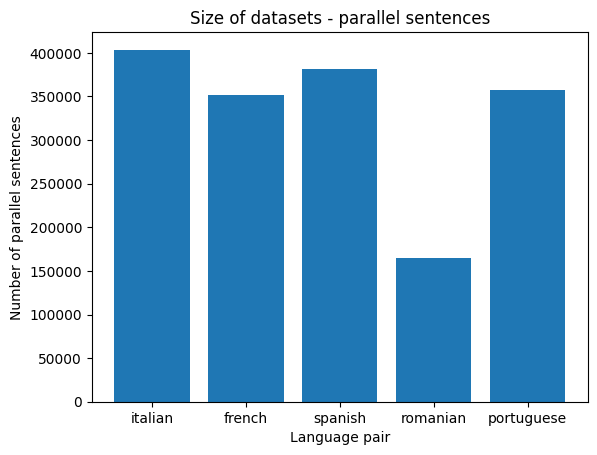

In [ ]:
#@title Dataset size
#Dictionary to store the dataset sizes
dataset_sizes = {}

#Calculate the size of each dataset
for language_name, language_df in languages.items():
    dataset_sizes[language_name] = len(language_df)

#Create the bar chart
fig, ax = plt.subplots()

#Extract the language names and dataset sizes
languages = list(dataset_sizes.keys())
sizes = list(dataset_sizes.values())

#Set the positions of the bars on the x-axis
x_pos = range(len(languages))

#Create the bar chart
ax.bar(x_pos, sizes, align='center')

#Set the tick labels on the x-axis
ax.set_xticks(x_pos)
ax.set_xticklabels(languages)

#Set the labels and title of the plot
ax.set_xlabel('Language pair')
ax.set_ylabel('Number of parallel sentences')
ax.set_title('Size of datasets - parallel sentences')

#Show the plot
plt.show()

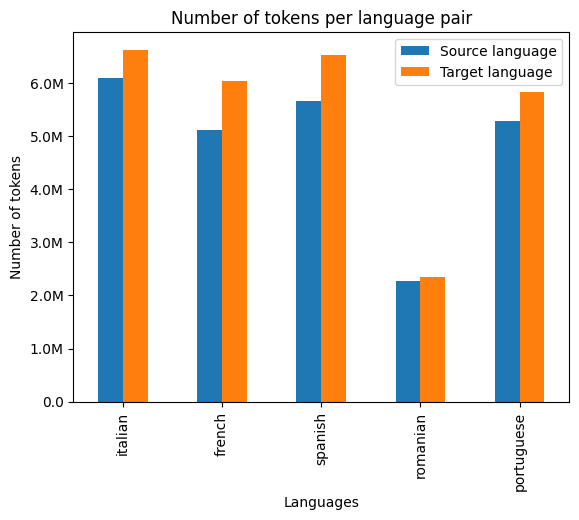

In [ ]:
#@title Number of tokens
#Count the tokens
language_names = []
source_token_counts = []
target_token_counts = []

for language_name, language_df in languages.items():
  total_source_tokens = language_df['sourceExpression_tokenize'].str.split().str.len().sum()
  total_target_tokens = language_df['targetExpression_tokenize'].str.split().str.len().sum()

  language_names.append(language_name)
  source_token_counts.append(total_source_tokens)
  target_token_counts.append(total_target_tokens)

#Creating a dataframe for plotting
data = pd.DataFrame({'Language': language_names,
                     'Source language': source_token_counts,
                     'Target language': target_token_counts})

#Plotting the counts
ax = data.plot(x='Language', y=['Source language', 'Target language'], kind='bar')

#Formatting the y-axis tick labels
def format_ticks(value, _):
    if value >= 1e6:
        value = f'{value/1e6:.1f}M'
    elif value >= 1e3:
        value = f'{value/1e3:.1f}K'
    return value

ax.yaxis.set_major_formatter(FuncFormatter(format_ticks))

# Adding labels and title
plt.xlabel('Languages')
plt.ylabel('Number of tokens')
plt.title('Number of tokens per language pair')
plt.legend()
plt.show()


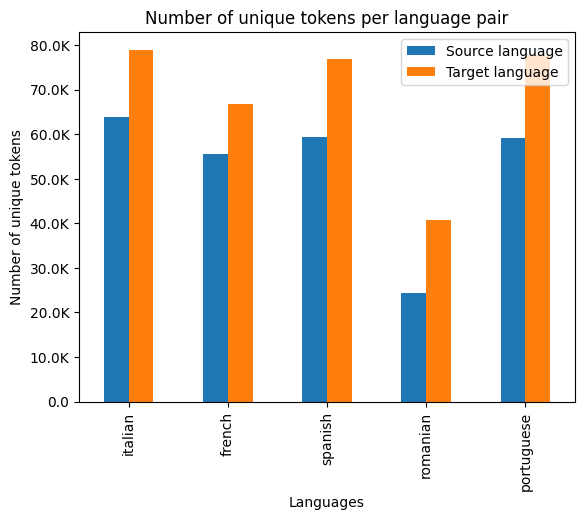

In [ ]:
#@title Number of unique tokens
#Count the unique tokens
language_names = []
source_unique_token_counts = []
target_unique_token_counts = []

for language_name, language_df in languages.items():
    unique_source_tokens = set()
    unique_target_tokens = set()

    for tokens in language_df['sourceExpression_tokenize'].str.split():
        unique_source_tokens.update(tokens)

    for tokens in language_df['targetExpression_tokenize'].str.split():
        unique_target_tokens.update(tokens)

    language_names.append(language_name)
    source_unique_token_counts.append(len(unique_source_tokens))
    target_unique_token_counts.append(len(unique_target_tokens))

# Creating a dataframe for plotting
data = pd.DataFrame({'Language': language_names,
                     'Source language': source_unique_token_counts,
                     'Target language': target_unique_token_counts})

# Plotting the counts
ax = data.plot(x='Language', y=['Source language', 'Target language'], kind='bar')

# Formatting the y-axis tick labels
def format_ticks(value, _):
    if value >= 1e6:
        value = f'{value/1e6:.1f}M'
    elif value >= 1e3:
        value = f'{value/1e3:.1f}K'
    return value

ax.yaxis.set_major_formatter(FuncFormatter(format_ticks))

# Adding labels and title
plt.xlabel('Languages')
plt.ylabel('Number of unique tokens')
plt.title('Number of unique tokens per language pair')
plt.legend()
plt.show()

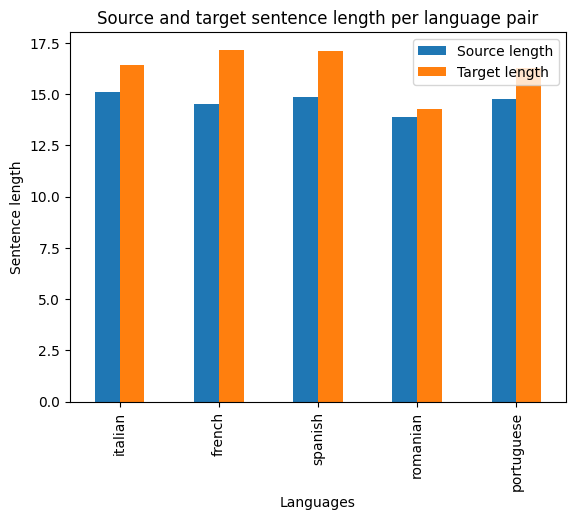

In [ ]:
#@title Mean sentence length
language_names = []
source_lengths = []
target_lengths = []

for language_name, language_df in languages.items():
  language_df['sourceLength'] = language_df['sourceExpression_tokenize'].apply(lambda x: len(x.split()))
  language_df['targetLength'] = language_df['targetExpression_tokenize'].apply(lambda x: len(x.split()))

  language_names.append(language_name)
  source_lengths.append(language_df['sourceLength'].mean())
  target_lengths.append(language_df['targetLength'].mean())

#Creating a dataframe for plotting
data = pd.DataFrame({'Language': language_names,
                     'Source length': source_lengths,
                     'Target length': target_lengths})

#Plotting the lengths
ax = data.plot(x='Language', y=['Source length', 'Target length'], kind='bar')

#Formatting the y-axis tick labels
def format_ticks(value, _):
    if value >= 1e6:
        value = f'{value/1e6:.1f}M'
    elif value >= 1e3:
        value = f'{value/1e3:.1f}K'
    return value

ax.yaxis.set_major_formatter(FuncFormatter(format_ticks))

# Adding labels and title
plt.xlabel('Languages')
plt.ylabel('Sentence length')
plt.title('Source and target sentence length per language pair')
plt.legend()
plt.show()

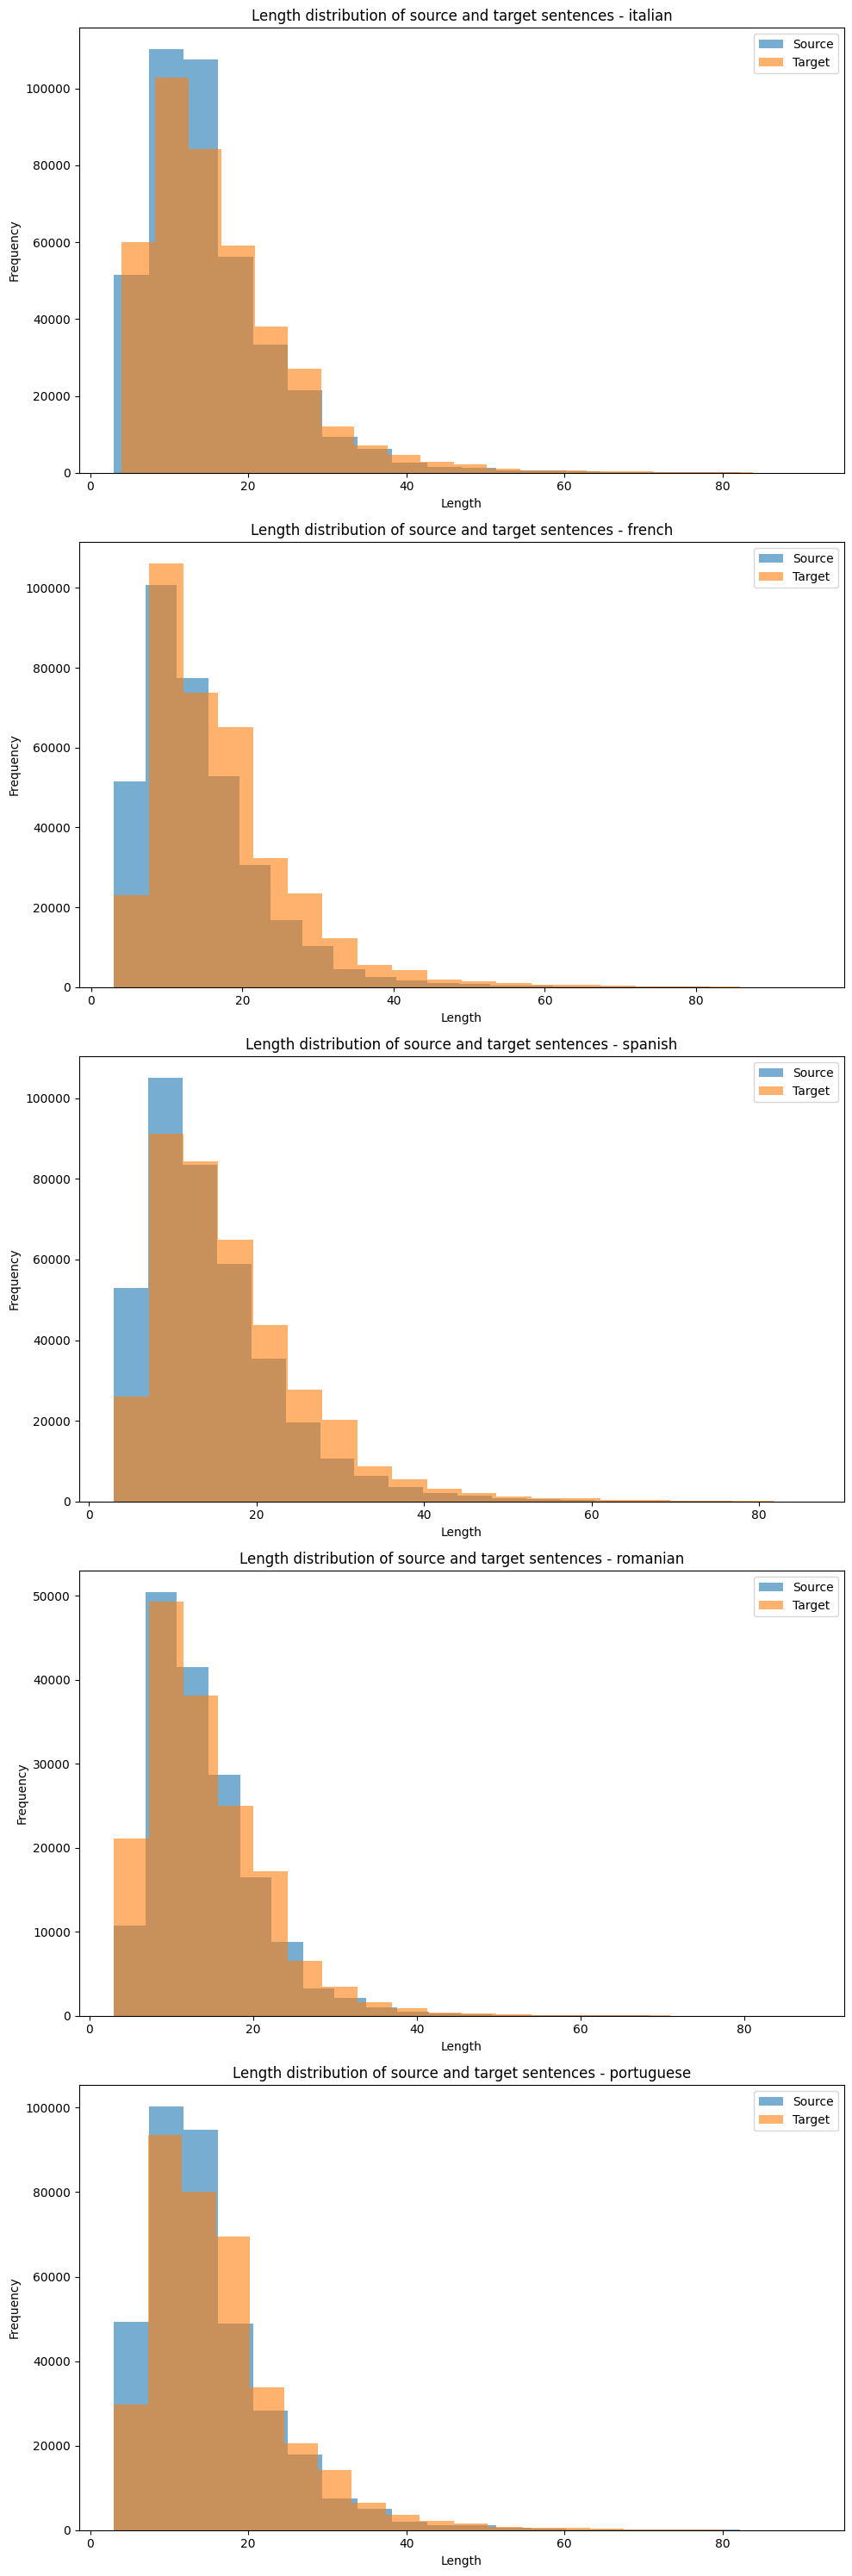

In [ ]:
#@title Distribution of sentence length
#Let's see the distribution of the sentence length
fig, axs = plt.subplots(len(languages), 1, figsize=(10, len(languages) * 6))

for i, (language_name, language_df) in enumerate(languages.items()):
    axs[i].hist(language_df['sourceLength'], bins=20, alpha=0.6, label='Source')
    axs[i].hist(language_df['targetLength'], bins=20, alpha=0.6, label='Target')
    axs[i].set_xlabel('Length')
    axs[i].set_ylabel('Frequency')
    axs[i].set_title(f'Length distribution of source and target sentences - {language_name}')
    axs[i].legend()

#Adjust spacing between subplots
plt.tight_layout()

#Show the plot
plt.show()

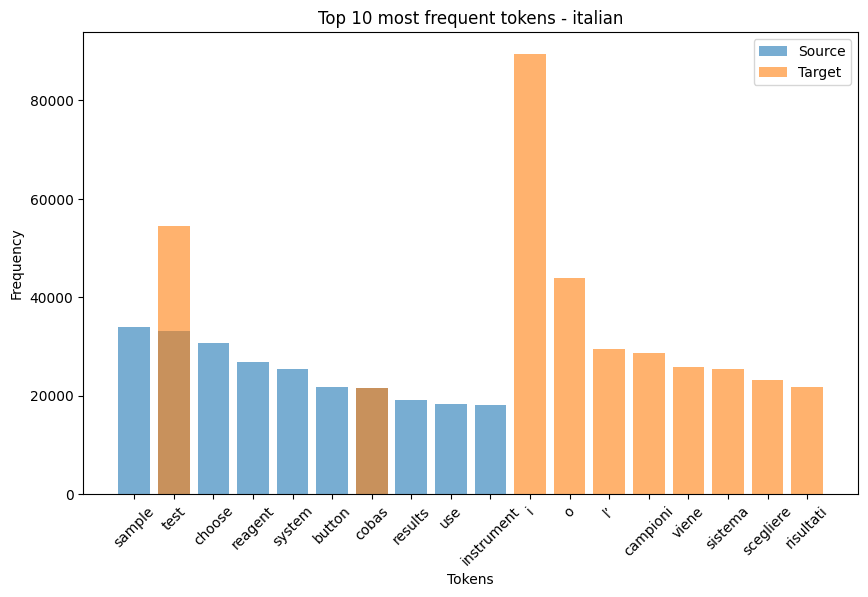

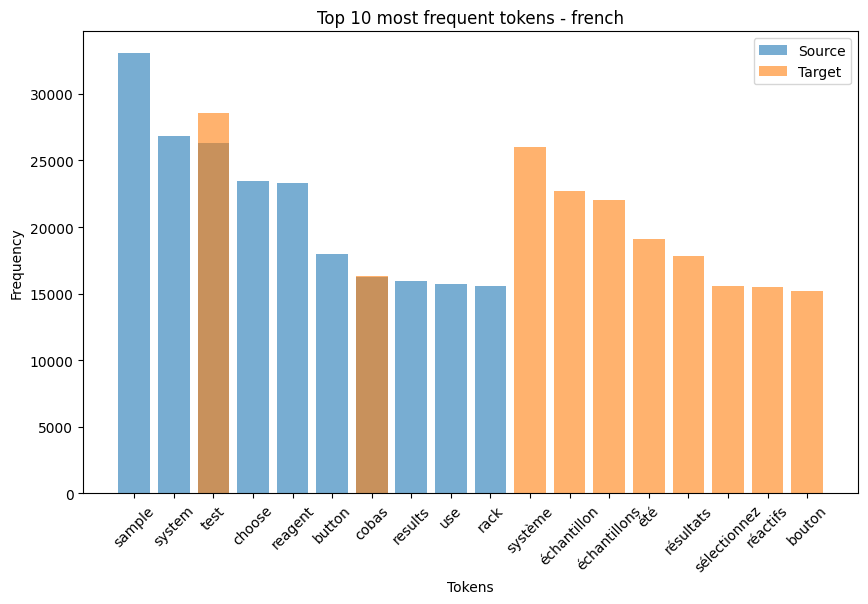

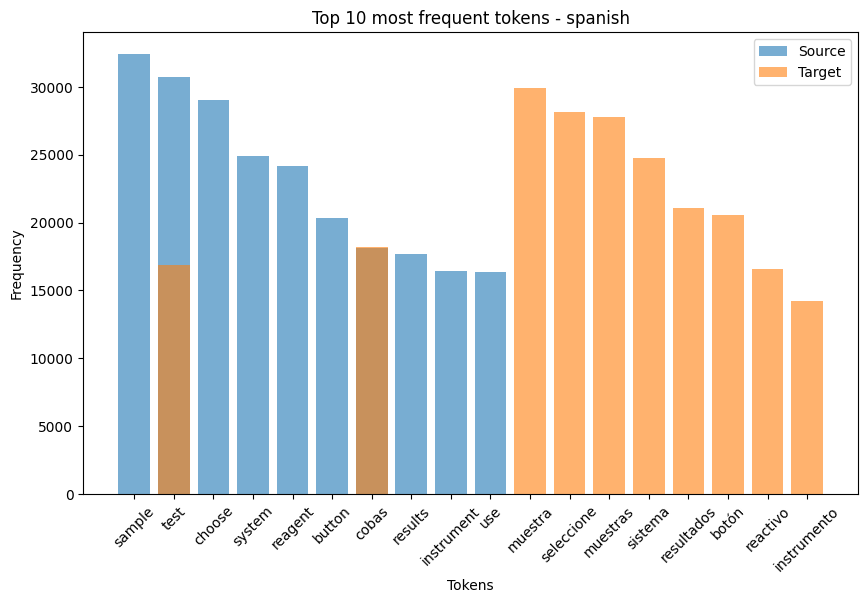

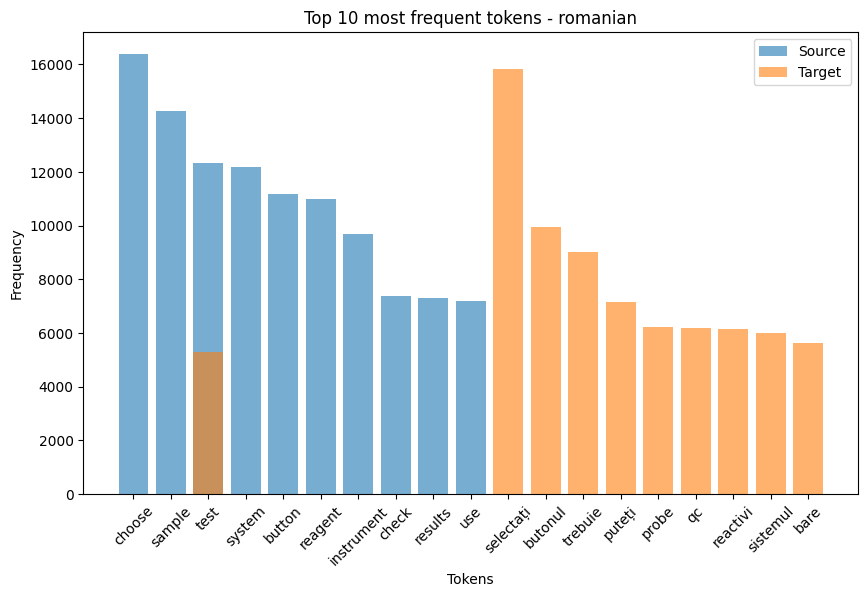

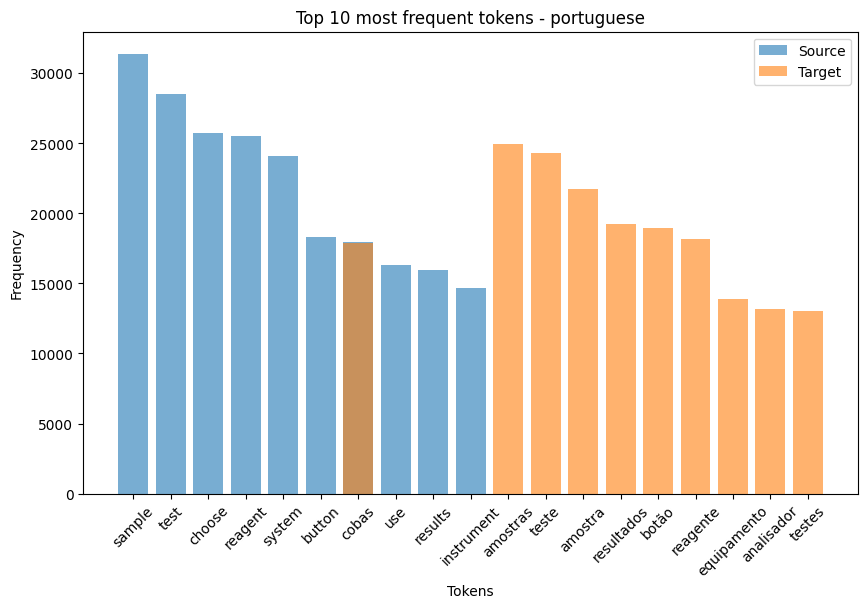

In [ ]:
#@title Most frequent tokens
#Let's see the most 10 frequent words, omitting the stopwords
top_n = 10

for language_name, language_df in languages.items():
    source_tokens = language_df['sourceExpression_tokenize-full'].str.split().explode()
    target_tokens = language_df['targetExpression_tokenize-full'].str.split().explode()

    #Count the occurrences of each unique token
    source_token_counts = Counter(source_tokens)
    target_token_counts = Counter(target_tokens)

    #Get the top N most frequent tokens
    source_top_tokens = source_token_counts.most_common(top_n)
    target_top_tokens = target_token_counts.most_common(top_n)

    #Extract the token and frequency information
    source_top_tokens, source_top_token_counts = zip(*source_top_tokens)
    target_top_tokens, target_top_token_counts = zip(*target_top_tokens)

    #Plotting the top frequent tokens
    plt.figure(figsize=(10, 6))
    plt.bar(source_top_tokens, source_top_token_counts, alpha=0.6, label='Source')
    plt.bar(target_top_tokens, target_top_token_counts, alpha=0.6, label='Target')
    plt.xlabel('Tokens')
    plt.ylabel('Frequency')
    plt.title(f'Top {top_n} most frequent tokens - {language_name}')
    plt.legend()
    plt.xticks(rotation=45)
    plt.show()